In [1]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [2]:
# Load and preprocess the Iris dataset
iris = datasets.load_iris()
X, y = iris.data, iris.target
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [3]:
import numpy as np

In [4]:
# neural network parameters
n_hidden = 10
learning_rate = 0.01
epochs = 500

In [5]:
# Cuckoo Search parameters
n_pop = 250
n_iterations = 1000
pa = 0.5
n_inputs = X.shape[1]
n_outputs = len(np.unique(y))
solution_size = n_inputs * n_hidden + n_hidden * n_outputs + n_hidden + n_outputs

In [6]:
from sklearn.model_selection import KFold

In [7]:
# Train the neural network using Cuckoo Search
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

10

In [8]:
# Store all metrics in a dictionary for easy retrieval later
metrics_backprop = {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "confusion_matrix": []}
metrics_cuckoo = {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "confusion_matrix": []}

In [9]:
from models import train_nn, predict_nn, cuckoo_search, feedforward, decode_solution
from utils import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [10]:
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_true_train, y_true_test = y[train_index], y[test_index]
    
    # Train the neural network using backpropagation
    W1, b1, W2, b2, backprop_loss = train_nn(X_train, y_true_train)
    
    # Test the trained neural network using backpropagation
    y_pred_test = predict_nn(X_test, W1, b1, W2, b2)
    
    # Store the performance metrics
    metrics_backprop["accuracy"].append(accuracy_score(y_true_test, y_pred_test))
    metrics_backprop["precision"].append(precision_score(y_true_test, y_pred_test, average="weighted"))
    metrics_backprop["recall"].append(recall_score(y_true_test, y_pred_test, average="weighted"))
    metrics_backprop["f1_score"].append(f1_score(y_true_test, y_pred_test, average="weighted"))
    metrics_backprop["confusion_matrix"].append(confusion_matrix(y_true_test, y_pred_test))
    
    
    # Train the neural network using Cuckoo Search
    best_solution, cuckoo_loss = cuckoo_search(X_train, y_true_train, n_pop, n_iterations, pa, n_inputs, n_hidden, n_outputs, solution_size)
    
    # Apply the best solution to the neural network
    weights, biases = decode_solution(best_solution, n_inputs, n_hidden, n_outputs)
    
    # Test the trained neural network
    output_test = feedforward(X_test, weights, biases)
    y_pred_test = np.argmax(output_test, axis=1)

    # Store the performance metrics
    metrics_cuckoo["accuracy"].append(accuracy_score(y_true_test, y_pred_test))
    metrics_cuckoo["precision"].append(precision_score(y_true_test, y_pred_test, average="weighted"))
    metrics_cuckoo["recall"].append(recall_score(y_true_test, y_pred_test, average="weighted"))
    metrics_cuckoo["f1_score"].append(f1_score(y_true_test, y_pred_test, average="weighted"))
    metrics_cuckoo["confusion_matrix"].append(confusion_matrix(y_true_test, y_pred_test))


In [11]:
# Calculate the mean of metrics
mean_metrics_backprop = {metric: np.mean(values) for metric, values in metrics_backprop.items() if metric != "confusion_matrix"}
mean_metrics_cuckoo = {metric: np.mean(values) for metric, values in metrics_cuckoo.items() if metric != "confusion_matrix"}

# metrics names
metrics_names = mean_metrics_backprop.keys()

In [12]:
# Print the results
print("Backpropagation")
for metric in metrics_names:
    print(f"{metric}: {mean_metrics_backprop[metric] * 100 :.4f} %")
print()

print("Cuckoo Search")
for metric in metrics_names:
    print(f"{metric}: {mean_metrics_cuckoo[metric] * 100 :.4f} %")


Backpropagation
accuracy: 96.0000 %
precision: 96.8952 %
recall: 96.0000 %
f1_score: 95.7590 %

Cuckoo Search
accuracy: 93.3333 %
precision: 95.0397 %
recall: 93.3333 %
f1_score: 93.2934 %


In [13]:
import matplotlib.pyplot as plt

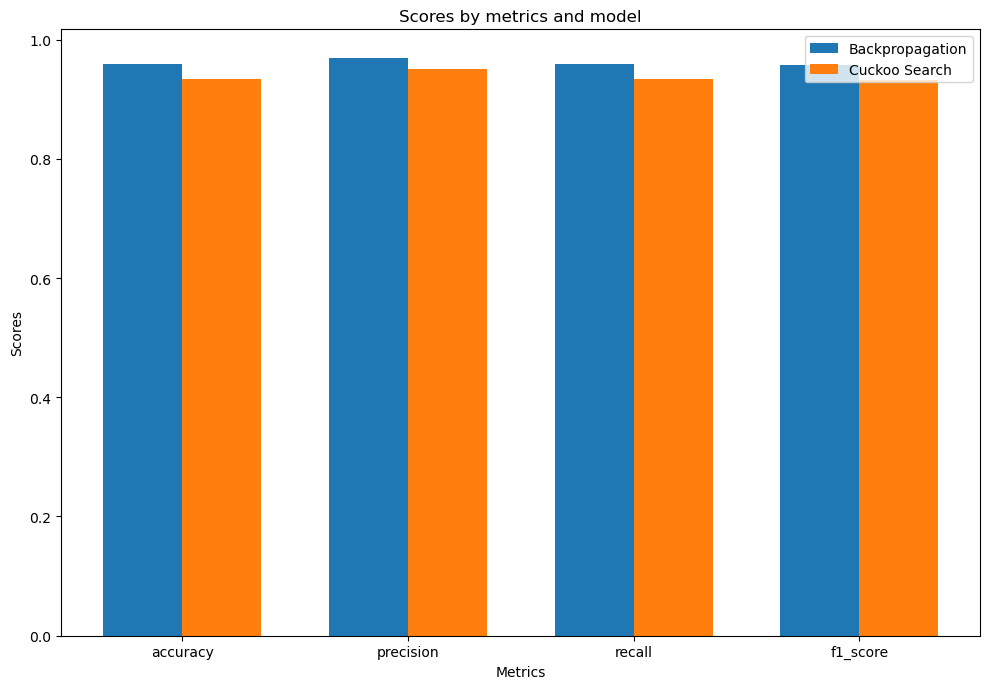

In [14]:
plt.rcParams["figure.figsize"] = (10,7)

# create figure and axis objects
fig, ax = plt.subplots()

# create index for each metric
index = np.arange(len(metrics_names))

# define bar width
bar_width = 0.35

# create backpropagation performance bars
rects1 = ax.bar(index, mean_metrics_backprop.values(), bar_width, label="Backpropagation")

# create cuckoo search performance bars
rects2 = ax.bar(index + bar_width, mean_metrics_cuckoo.values(), bar_width, label="Cuckoo Search")

# adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Scores by metrics and model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_names)
ax.legend()

fig.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay


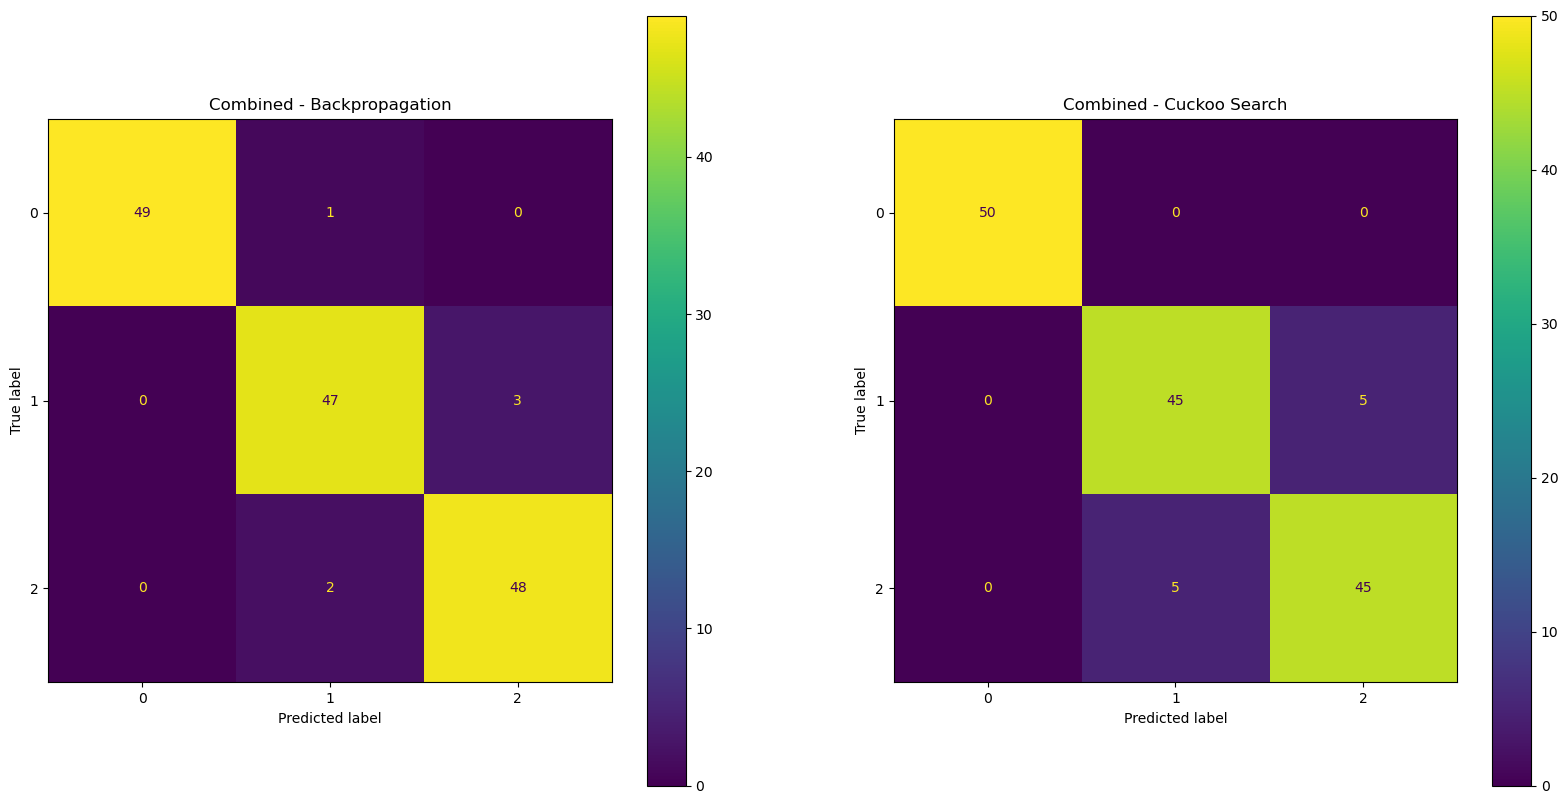

In [16]:
# Sum up the confusion matrices for each model
combined_cm_backprop = np.sum(metrics_backprop["confusion_matrix"], axis=0)
combined_cm_cuckoo = np.sum(metrics_cuckoo["confusion_matrix"], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Display the combined confusion matrix for the backpropagation model
ConfusionMatrixDisplay(combined_cm_backprop).plot(ax=axs[0])
axs[0].set_title("Combined - Backpropagation")
axs[0].set_xlabel("Predicted label")
axs[0].set_ylabel("True label")

# Display the combined confusion matrix for the cuckoo search model
ConfusionMatrixDisplay(combined_cm_cuckoo).plot(ax=axs[1])
axs[1].set_title("Combined - Cuckoo Search")
axs[1].set_xlabel("Predicted label")
axs[1].set_ylabel("True label")

plt.show()